In [1]:
from __future__ import annotations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import gymnasium as gym

array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
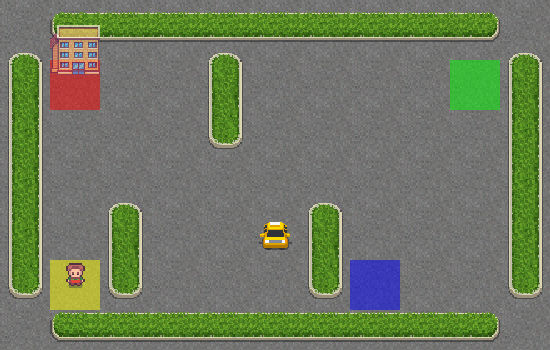

In [2]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
state,_ = env.reset()
env.render()

In [3]:
env.action_space


Discrete(6)

Hay 6 acciones disponibles, tales como mover (4) y pick-up y dejar el pasajero.

In [4]:
env.observation_space

Discrete(500)

 Los 500 estados provienen de la combinación de las posibles posiciones del taxi, la ubicación del pasajero y la ubicación de destino del pasajero.

La recompensa por cualquier acción legal que no implique en recoger o dejar el pasajero es -1, un pick-up es 20 puntos y dejar el pasajero en el destino es 30, es decir, la condición de terminación es que el pasajero se ubique en el destino.

# MC ON-POLICY CONTROL



# Creamos la tabla Q para estado-acción

In [5]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))

# Creamos la tabla de return (S,a)

In [6]:
returns = defaultdict(list)


# Inicializamos un ε-soft policy

In [7]:
def initialize_epsilon_soft_policy():
        policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
        return policy

In [8]:
pi = initialize_epsilon_soft_policy()

# Hiperparámetro

In [9]:
gamma=1.0
epsilon=0.1

# Actualización de valor




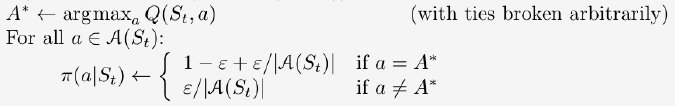

In [10]:
def update_policy(state):
        """Update the policy to be ε-soft greedy with respect to Q"""
        n_actions = env.action_space.n
        best_action = np.argmax(Q[state])

        # Create ε-soft policy
        new_policy = np.ones(n_actions) * (epsilon / n_actions)
        new_policy[best_action] += (1 - epsilon)

        pi[state] = new_policy

# Generación de episodio

In [11]:
def generate_episode(max_steps=1000):
        """Generate an episode following the current policy π"""
        episode = []
        state = env.reset()

        for step in range(max_steps):
            # Choose action according to current policy
            if isinstance(state, tuple):
                state_key = state[0] if isinstance(state, tuple) else state
            else:
                state_key = state

            action_probs = pi[state_key]
            action = np.random.choice(len(action_probs), p=action_probs)

            # Take action
            next_state, reward, done, truncated, info = env.step(action)

            # Store experience
            episode.append((state, action, reward))

            state = next_state

            if done or truncated:
                break

        return episode

# Aprendizaje

In [12]:
def learn(num_episodes=10000):
        """Learn the optimal policy using on-policy first-visit MC control"""
        for episode_num in range(num_episodes):
            # Generate an episode following π
            episode = generate_episode()
            T = len(episode)

            G = 0  # Return
            visited_state_actions = set()

            # Loop backwards through the episode
            for t in range(T-1, -1, -1):
                state, action, reward = episode[t]

                # Convert state to hashable key
                if isinstance(state, tuple):
                    state_key = state[0] if isinstance(state, tuple) else state
                else:
                    state_key = state

                state_action = (state_key, action)

                # Update return
                G = gamma * G + reward

                # First-visit: only update if this is the first time visiting (s,a)
                if state_action not in visited_state_actions:
                    visited_state_actions.add(state_action)

                    # Append G to Returns(s,a)
                    returns[state_action].append(G)

                    # Update Q(s,a) as average of Returns(s,a)
                    Q[state_key][action] = np.mean(returns[state_action])

                    # Update policy for this state
                    update_policy(state_key)

            # Print progress
            if (episode_num + 1) % 1000 == 0:
                print(f"Episode {episode_num + 1}/{num_episodes}")



In [13]:
learn(num_episodes=20000) # Puedes ajustar el número de episodios si es necesario

Episode 1000/20000
Episode 2000/20000
Episode 3000/20000
Episode 4000/20000
Episode 5000/20000
Episode 6000/20000
Episode 7000/20000
Episode 8000/20000
Episode 9000/20000
Episode 10000/20000
Episode 11000/20000
Episode 12000/20000
Episode 13000/20000
Episode 14000/20000
Episode 15000/20000
Episode 16000/20000
Episode 17000/20000
Episode 18000/20000
Episode 19000/20000
Episode 20000/20000


# Mostración

In [14]:
def get_action( state, greedy=False):
        """Get action from current policy"""
        if isinstance(state, tuple):
            state_key = state[0] if isinstance(state, tuple) else state
        else:
            state_key = state

        if greedy:
            # Return greedy action
            return np.argmax(Q[state_key])
        else:
            # Sample from policy
            action_probs = pi[state_key]
            return np.random.choice(len(action_probs), p=action_probs)

Ahora, para visualizar un episodio usando la política aprendida, generar un nuevo episodio y renderizarlo.

In [15]:
def visualize_learned_policy(env, get_action_func, max_steps=100):
    """Visualizes an episode using the learned policy"""
    state, _ = env.reset()
    frames = []
    for step in range(max_steps):
        frame = env.render()
        frames.append(frame)

        action = get_action_func(state, greedy=True) # Use greedy policy for visualization

        next_state, reward, done, truncated, info = env.step(action)
        state = next_state

        if done or truncated:
            break
    env.close()
    return frames

frames = visualize_learned_policy(env, get_action)

# Function to display the animation (requires matplotlib)
def display_animation(frames, repeat=False, interval=50):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=interval, repeat=repeat)
    display(HTML(anim.to_jshtml()))
    plt.close() # Close the plot to avoid displaying the last frame as a static image

display_animation(frames)

Output hidden; open in https://colab.research.google.com to view.

# **Q-Learning DOUBLE Q TABLE**







#Doble tabla


In [16]:
Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
Q2 = defaultdict(lambda: np.zeros(env.action_space.n))

#Hiperparámetros


In [17]:
alpha = 0.1       # tasa de aprendizaje
gamma = 0.99      # factor de descuento
epsilon = 0.1     # exploración

#Política e-greedy

In [18]:
def epsilon_greedy_policy(state):
    Q_sum = Q1[state] + Q2[state]
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q_sum)

#Entrenamiento

In [19]:
def learn(num_episodes):
  # Entrenamiento
  for episode in range(num_episodes):
      state, _ = env.reset()
      done = False

      while not done:
          action = epsilon_greedy_policy(state)
          next_state, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated

          if np.random.random() < 0.5:
              # Actualizar Q1
              a_star = np.argmax(Q1[next_state])
              Q1[state][action] += alpha * (reward + gamma * Q2[next_state][a_star] - Q1[state][action])
          else:
              # Actualizar Q2
              a_star = np.argmax(Q2[next_state])
              Q2[state][action] += alpha * (reward + gamma * Q1[next_state][a_star] - Q2[state][action])

          state = next_state

In [20]:
learn(5000) # Puedes ajustar el número de episodios si es necesario

#Tabla final

In [21]:
# Tabla Q final (promedio de ambas)
Q_f= defaultdict(lambda: np.zeros(env.action_space.n))
for s in set(Q1.keys()).union(set(Q2.keys())):
    Q_f[s] = (Q1[s] + Q2[s]) / 2


In [22]:
policy = {s: np.argmax(Q_f[s]) for s in Q_f.keys()}
print("Política óptima derivada:")
for s in sorted(policy.keys()):
    print(f"Estado {s}: Acción {policy[s]}")

Política óptima derivada:
Estado 0: Acción 0
Estado 1: Acción 4
Estado 2: Acción 4
Estado 3: Acción 4
Estado 4: Acción 0
Estado 6: Acción 3
Estado 7: Acción 2
Estado 8: Acción 0
Estado 9: Acción 0
Estado 11: Acción 0
Estado 12: Acción 0
Estado 13: Acción 0
Estado 14: Acción 2
Estado 16: Acción 5
Estado 17: Acción 0
Estado 18: Acción 0
Estado 19: Acción 0
Estado 21: Acción 3
Estado 22: Acción 3
Estado 23: Acción 3
Estado 24: Acción 0
Estado 26: Acción 0
Estado 27: Acción 0
Estado 28: Acción 3
Estado 29: Acción 0
Estado 31: Acción 3
Estado 32: Acción 0
Estado 33: Acción 0
Estado 34: Acción 0
Estado 36: Acción 3
Estado 37: Acción 0
Estado 38: Acción 3
Estado 39: Acción 0
Estado 41: Acción 0
Estado 42: Acción 0
Estado 43: Acción 0
Estado 44: Acción 2
Estado 46: Acción 2
Estado 47: Acción 2
Estado 48: Acción 0
Estado 49: Acción 0
Estado 51: Acción 0
Estado 52: Acción 0
Estado 53: Acción 2
Estado 54: Acción 2
Estado 56: Acción 0
Estado 57: Acción 2
Estado 58: Acción 2
Estado 59: Acción 2
Est

#Mostración del resultado de aprendizaje
LONG LIVE GEMINI

In [23]:
def get_action_double_q(state):
    """Get greedy action from the Q_f table for Double Q-learning"""
    # Handle state format if it's a tuple (e.g., from env.reset())
    if isinstance(state, tuple):
        state_key = state[0] if isinstance(state, tuple) else state
    else:
        state_key = state

    # Return the action with the maximum Q-value from Q_f
    return np.argmax(Q_f[state_key])

print("Function 'get_action_double_q' defined.")

Function 'get_action_double_q' defined.


In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def visualize_learned_policy(env, get_action_func, max_steps=100):
    """Visualizes an episode using the learned policy"""
    state, _ = env.reset()
    frames = []
    for step in range(max_steps):
        frame = env.render()
        frames.append(frame)

        action = get_action_func(state) # Use greedy policy for visualization

        next_state, reward, done, truncated, info = env.step(action)
        state = next_state

        if done or truncated:
            break
    env.close()
    return frames

# Function to display the animation (requires matplotlib)
def display_animation(frames, repeat=False, interval=50):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=interval, repeat=repeat)
    display(HTML(anim.to_jshtml()))
    plt.close() # Close the plot to avoid displaying the last frame as a static image

frames_double_q = visualize_learned_policy(env, get_action_double_q)

print("Displaying Double Q-learning policy animation...")
display_animation(frames_double_q)


Output hidden; open in https://colab.research.google.com to view.

# **N-STEP SARSA**

In [25]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# MOVING AVERAGE

In [26]:
def moving_average(x, w=100):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    s = 0.0
    k = 0
    for i, v in enumerate(x):
        s += v; k += 1
        if k > w:
            s -= x[i - w]; k -= 1
        out[i] = s / k
    return out

# Política e-greedy

In [27]:
def epsilon_greedy(Q, state, n_actions, epsilon):
    # Handle state format if it's a tuple (e.g., from env.reset())
    if isinstance(state, tuple):
        state_key = state[0]
    else:
        state_key = state

    if random.random() < epsilon:
        return random.randrange(n_actions)
    # Use state_key for Q-table lookup
    q_vals = [Q[(state_key, a)] for a in range(n_actions)]
    max_q = max(q_vals)
    actions = [a for a, q in enumerate(q_vals) if q == max_q]
    return random.choice(actions)

# N-STEP SARASA

In [28]:
def n_step_sarsa(env, n, alpha, gamma, epsilon, num_episodes, max_steps=1000):
    """
    Implementa el algoritmo n-step SARSA.

    Parámetros:
        env: entorno compatible con gym (o similar)
        n: número de pasos de la actualización (n-step)
        alpha: tasa de aprendizaje
        gamma: factor de descuento
        epsilon: parámetro de la política ε-greedy
        num_episodes: número de episodios de entrenamiento
        max_steps: límite máximo de pasos por episodio
    """
    Q = defaultdict(float)
    n_actions = env.action_space.n

    rewards_per_ep = []
    mean_abs_td_per_ep = []

    for _ in range(num_episodes):
        S, A, R = [], [], [0.0]
        s, info = env.reset() # env.reset() returns (observation, info) in newer gym versions
        S.append(s)
        A.append(epsilon_greedy(Q, s, n_actions, epsilon))

        T_terminal_step = float('inf') # Actual step where episode truly ends (if done/truncated)
        t = 0
        abs_td_values = []

        # Initialize current_T_effective to max_steps, it will be updated if the episode terminates earlier
        current_T_effective = max_steps

        while True:
            # Paso del entorno
            if t < T_terminal_step:
                s_next, r, done, truncated, info = env.step(A[t])
                S.append(s_next)
                R.append(r)
                if done or truncated:
                    T_terminal_step = t + 1 # Episode ended naturally at this step
                    current_T_effective = T_terminal_step # Update effective termination step
                else:
                    A.append(epsilon_greedy(Q, s_next, n_actions, epsilon))

            tau = t - n + 1
            if tau >= 0:
                # Use the already established current_T_effective
                t_end = min(tau + n, int(current_T_effective))

                G = sum((gamma ** (i - tau - 1)) * R[i] for i in range(tau + 1, t_end + 1))
                if tau + n < current_T_effective:
                    # Ensure the state used for Q-lookup is hashable
                    q_lookup_state = S[tau + n] if not isinstance(S[tau + n], tuple) else S[tau + n][0]
                    G += (gamma ** n) * Q[(q_lookup_state, A[tau + n])]

                # Actualización de Q
                # Ensure the state used for Q-lookup is hashable
                q_lookup_state_tau = S[tau] if not isinstance(S[tau], tuple) else S[tau][0]
                delta = G - Q[(q_lookup_state_tau, A[tau])]
                Q[(q_lookup_state_tau, A[tau])] += alpha * delta
                abs_td_values.append(abs(delta))

            # Loop termination conditions
            # Break if all relevant tau values have been processed based on the effective episode length.
            if tau == current_T_effective - 1:
                break
            t += 1
            # If the episode runs longer than max_steps, it should also terminate.
            # The `tau == current_T_effective - 1` condition, with current_T_effective being max_steps,
            # should effectively handle this for most cases.
            # We can keep this explicit check for robustness, but it should logically be covered.
            if t >= max_steps and T_terminal_step == float('inf'): # Break if max steps reached and no natural termination
                break

        rewards_per_ep.append(sum(R[1:]))  # recompensa total del episodio
        # Only calculate mean_abs_td_per_ep if abs_td_values is not empty
        if abs_td_values:
            mean_abs_td_per_ep.append(np.mean(abs_td_values))
        else:
            mean_abs_td_per_ep.append(0.0) # Append 0 if no TD errors were calculated (e.g., very short episode)
    return Q, rewards_per_ep, mean_abs_td_per_ep

In [29]:
alpha, gamma, epsilon = 0.5, 1.0, 0.1
num_episodes = 500
n_values = [1, 2, 4, 6, 8]

results = {}
for n in n_values:
    Q_n, rewards_n, td_error_n = n_step_sarsa(env, n, alpha, gamma, epsilon, num_episodes)
    results[n] = {
        "rewards": moving_average(rewards_n, w=20),
        "td_error": moving_average(td_error_n, w=20)
    }

# Gráfica

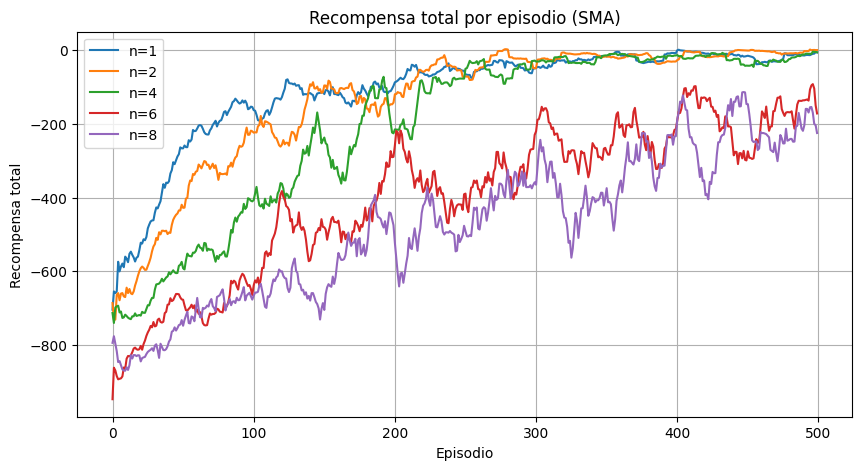

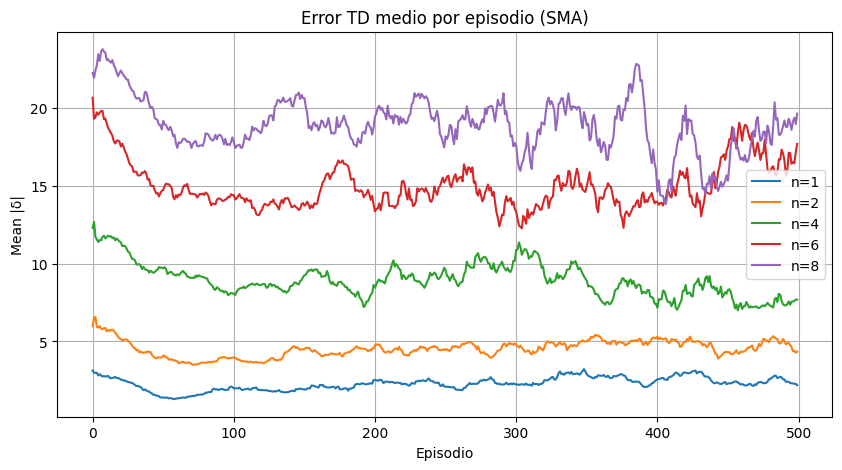

In [30]:
# --- Gráficas ---
plt.figure(figsize=(10, 5))
for n in n_values:
    plt.plot(results[n]["rewards"], label=f"n={n}")
plt.title("Recompensa total por episodio (SMA)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for n in n_values:
    plt.plot(results[n]["td_error"], label=f"n={n}")
plt.title("Error TD medio por episodio (SMA)")
plt.xlabel("Episodio")
plt.ylabel("Mean |δ|")
plt.legend()
plt.grid(True)
plt.show()